In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

- [两资产](#two)

- [多资产MM](#MM)

- [引入无风险资产-MM2](#MM2)

# <span id='two'>两资产</span>
资产A，B收益率分别为5%，10%，波动率分别为15%，20%

对两个资产，取不同的相关系数ρ和组合比例，画出对应的图像

In [2]:
def portfolio1(ra, rb, sa, sb, rho, wa):
    wb = 1 - wa
    rp = wa*ra + wb*rb
    sp = ((wa**2)*(sa**2) + (wb**2)*(sb**2) + 2*wa*wb*sa*sb*rho) ** 0.5
    return rp, sp

In [3]:
ra = 0.05
rb = 0.1
sa = 0.15
sb = 0.2

rhos = np.arange(-10, 11, 2) / 10  # 相关系数ρ，-1 ~ 1
was = np.arange(101) / 100  # 资产A的权重，0 ~ 1

result = pd.DataFrame(columns=['rho', 'wa', 'rp', 'sp'])
for rho in rhos:
    for wa in was:
        rp, sp = portfolio1(ra, rb, sa, sb, rho, wa)
        x = pd.DataFrame([rho, wa, rp, sp]).T
        x.columns = ['rho', 'wa', 'rp', 'sp']
        result = result.append(x)
result = result.reset_index(drop=True)
result.head()

,rho,wa,rp,sp
0,-1.0,0.00,0.1000,0.2000
1,-1.0,0.01,0.0995,0.1965
2,-1.0,0.02,0.0990,0.1930
3,-1.0,0.03,0.0985,0.1895
4,-1.0,0.04,0.0980,0.1860


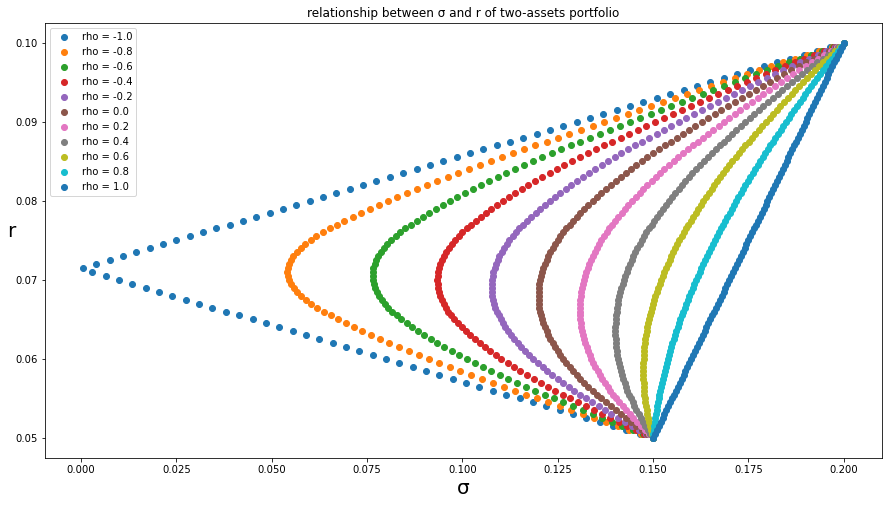

In [4]:
plt.figure(figsize=(15, 8))

for i in rhos:
    datas = result.loc[result.rho == i]
    plt.scatter(datas.sp, datas.rp, marker='o', label=f'rho = {i}')

plt.legend()
plt.xlabel('σ', fontsize=20)
plt.ylabel('r', fontsize=20, rotation=0)
plt.title('relationship between σ and r of two-assets portfolio')
plt.show()

# <span id='MM'>多资产MM</span>

以一段时间内资产的平均收益率作为期望收益率，标准差作为波动率

无风险收益率为4%，用于计算夏普指标

## 读取数据

使用五只股票（百度、阿里、腾讯、京东、拼多多）在过去一年间（2021.5.14 ~ 2022.5.13）的历史数据，取每日收盘价。数据来源Yahoo Finance

In [5]:
# 读取并整理数据
files = ['AMZN.csv', 'GCTAY.csv', 'AMD.csv', 'OPCH.csv', 'TSLA.csv']
data = {}

for (i, f) in enumerate(files):
    df = pd.read_csv(f)
    name = f.split('.')[0]

    # 取日期和收盘价
    data[name] = df.Close
    if i == len(files) - 1:
        data['date'] = df.Date

data_df = pd.DataFrame(data)
data_df['date'] = pd.to_datetime(data_df.date)
data_df.head()

,AMZN,GCTAY,AMD,OPCH,TSLA,date
0,3203.080078,6.42,77.169998,18.709999,580.880005,2021-05-21
1,3244.989990,6.33,77.440002,18.860001,606.440002,2021-05-24
2,3259.050049,6.45,77.860001,18.690001,604.690002,2021-05-25
3,3265.159912,6.51,78.339996,19.200001,619.130005,2021-05-26
4,3230.110107,6.45,78.419998,19.020000,630.849976,2021-05-27


In [6]:
datax = data_df.drop('date', axis=1)

## 1. 绘制可行集

随机生成出各种组合权重，计算各组合的收益和风险水平，在图中画出所有样本点（即可行集），根据组合的夏普比率进行着色，共模拟20000次

一年中的平均交易日数取252

In [7]:
def weights(n):
    """
    随机产生资产组合的权重向量w
    """
    # w = np.random.random(n)
    w = np.random.normal(0, 1, n)
    return w / w.sum()


def performance(price, w, have_riskfree=False):
    """
    给定各资产的价格数据price和资产组合权重向量w
    返回portfolio的平均收益率、标准差和夏普比率
    只考虑风险资产，所以如果w中包括无风险资产的wf，就把wf去掉
    """
    if have_riskfree:
        w = w[:-1]  # 去掉wf

    rf = 0.04  # 无风险收益率
    ret = price.pct_change()

    r_mean = ret.mean() * 252
    p_mean = np.sum(r_mean * w)

    r_cov = ret.cov() * 252
    p_var = np.dot(w.T, np.dot(r_cov, w))
    p_std = np.sqrt(p_var)

    p_sharpe = (p_mean-rf) / p_std

    return p_mean, p_std, p_sharpe

In [8]:
np.random.seed(1)
p_mean, p_std, p_sharpe = np.column_stack([performance(datax,weights(5)) for _ in range(20000)]) # 产生随机组合

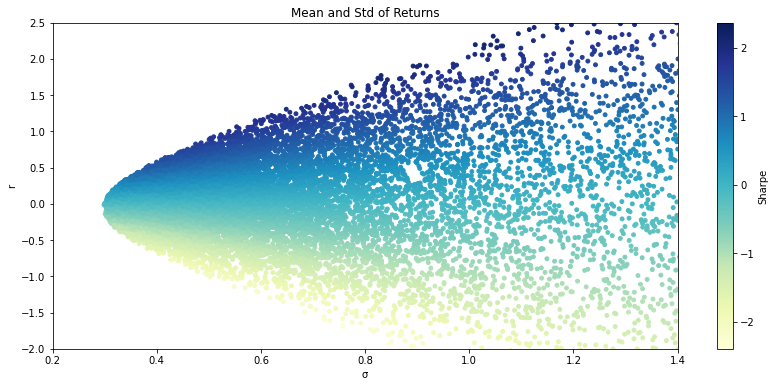

In [9]:
plt.figure(figsize=(14, 6))
plt.scatter(p_std, p_mean, c=p_sharpe, marker='o', cmap='YlGnBu', s=15)

plt.xlim([0.2, 1.4])
plt.ylim([-2, 2.5])
plt.xlabel('σ')
plt.ylabel('r')
plt.colorbar(label='Sharpe')
plt.title('Mean and Std of Returns')
plt.show()

## 2. 计算最小方差组合

求最小方差组合，使用`scipy.minimize`进行优化

In [10]:
def min_variance(w, datax, have_riskfree=False):
    return performance(datax, w, have_riskfree)[1] ** 2

In [11]:
con = ({'type': 'eq',
        'fun': lambda w: np.sum(w) - 1})

opt_v = minimize(min_variance,
                 x0=weights(5),
                 args=(datax,),
                 bounds=((0, 1), (0, 1), (0, 1), (0, 1), (0, 1)),
                 constraints=con)

In [12]:
opt_v.x

array([0.42865789, 0.19681996, 0.        , 0.33695795, 0.0375642 ])

In [13]:
# 最小方差点的portfolio
least_mean, least_std, least_sharpe = performance(datax, opt_v.x)
print(f"收益率为{least_mean}，标准差为{least_std}")

收益率为-0.04260275285084357，标准差为0.29839488395317076


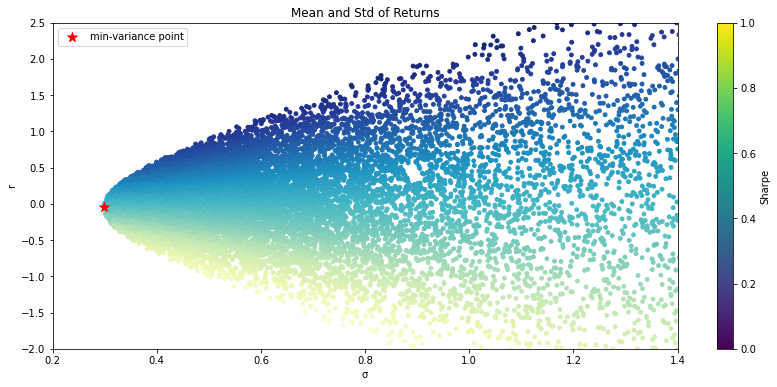

In [14]:
plt.figure(figsize=(14, 6))

# 画出可行集
plt.scatter(p_std, p_mean, c=p_sharpe, marker='o', cmap='YlGnBu', s=15)

# 标记最小方差组合
plt.scatter(least_std, least_mean, c='r', marker='*', s=100, label='min-variance point')

plt.xlim([0.2, 1.4])
plt.ylim([-2, 2.5])
plt.xlabel('σ')
plt.ylabel('r')
plt.colorbar(label='Sharpe')
plt.legend()
plt.title('Mean and Std of Returns')
plt.show()

## 3. 计算并绘制有效前沿

以最小方差下的收益为区间起点r_min，收益的6倍为区间终点，在区间内计算各收益r下的最优组合，得到有效前沿

和最小方差组合的优化问题相比，有效前沿的计算需要加入一个约束，即$r^T w = r_d$

In [15]:
r_min = least_mean
r_mean_list = np.linspace(r_min, r_min+0.5, 50)  # 划分650个r的取值

In [16]:
std_list = []
# 用scipy.minimize进行求解
for rd in r_mean_list:
    cons = ({'type': 'eq',
              'fun': lambda w: performance(datax, w)[0] - rd},  # rp = rd
             {'type': 'eq',
              'fun': lambda w: np.sum(w) - 1})  # e'w = 1
    opt_var = minimize(min_variance,
                       x0=weights(5),
                       method='SLSQP',
                       args=(datax,),
                       bounds=((0,1), (0,1), (0,1), (0,1), (0,1)),
                       constraints=cons)
    # 有效组合的std
    best_std = performance(datax,opt_var.x)[1] 
    std_list.append(best_std)

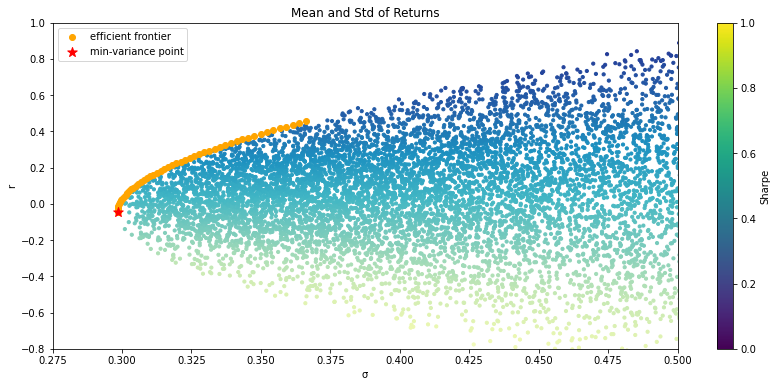

In [17]:
plt.figure(figsize=(14, 6))

# 画出可行集
plt.scatter(p_std, p_mean, c=p_sharpe, marker='o', cmap='YlGnBu', s=10)

# 标记有效前沿
plt.scatter(std_list[:60], r_mean_list[:60], marker='o', color='orange', label='efficient frontier')  

# 标记最小方差组合
plt.scatter(least_std, least_mean, c='r', marker='*', s=100, label='min-variance point') 

plt.xlim([0.275, 0.5])
plt.ylim([-0.8, 1])
plt.xlabel('σ')
plt.ylabel('r')
plt.colorbar(label='Sharpe')
plt.legend()
plt.title('Mean and Std of Returns')
plt.show()

# <span id='MM2'>引入无风险资产-MM2</span>

**说明**：切点组合的计算，分别在两个代码里使用了求解器和解析解进行求解，但发现两种方法求出的结果不同，且直接代入解析解求出的切点跑到了可行集的下方。

并没有成功发现错误出在哪里，于是把解析解求解的代码部分也搬到这份代码中放到一起作为对比。

## 计算切点投资组合

AMZN    -0.324283
GCTAY   -0.457469
AMD      0.338345
OPCH     0.519911
TSLA     0.299608
dtype: float64


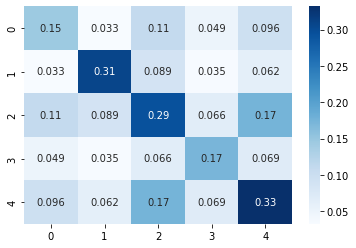

In [24]:
import seaborn as sns

r = datax.pct_change().mean() * 252  # --> 收益率向量
cov = datax.pct_change().cov().values * 252  # --> 协方差矩阵

print(r)
ax = sns.heatmap(cov, cmap='Blues', annot=True)

### 1) 用优化器计算

In [26]:
# 优化，最大化夏普比率（tanθ） -> 最小化【负的夏普比率】
def neg_sharp_ratio(w, rf=0.04):
    rp = np.sum(r * w)
    varp = np.dot(w.T, cov.dot(w))
    sigp = np.sqrt(varp)
    return -(rp - rf) / sigp


con = ({'type': 'eq',
        'fun': lambda w: np.sum(w) - 1})

opt_v_sharp = minimize(neg_sharp_ratio,
                       x0=weights(5),
                       bounds=((0, 1), (0, 1), (0, 1), (0, 1), (0, 1)),
                       constraints=con)

In [27]:
tan_mean0, tan_std0, _ = performance(datax, opt_v_sharp.x)
print(f"收益率为{tan_mean0}，标准差为{tan_std0}")

收益率为0.4938088412447727，标准差为0.3862281440046602


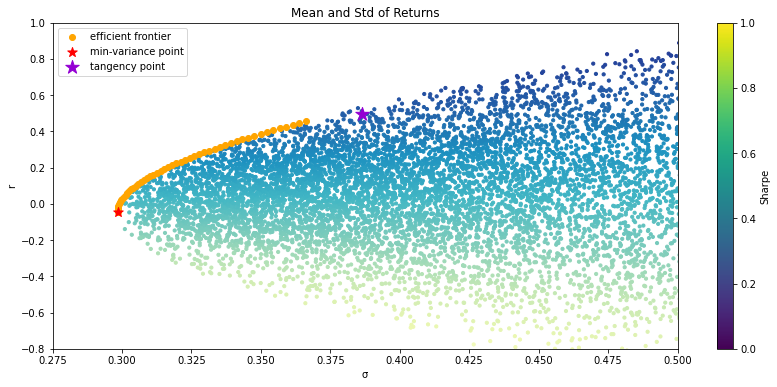

In [29]:
plt.figure(figsize=(14, 6))

# 画出可行集
plt.scatter(p_std, p_mean, c=p_sharpe, marker='o', cmap='YlGnBu', s=10)

# 标记有效前沿
plt.scatter(std_list, r_mean_list, marker='o', color='orange', label='efficient frontier')

# 标记最小方差组合
plt.scatter(least_std, least_mean, c='r', marker='*', s=100, label='min-variance point')

# 标记切点组合
plt.scatter(tan_std0, tan_mean0, c='darkviolet', marker='*', s=200, label='tangency point')

plt.xlim([0.275, 0.5])
plt.ylim([-0.8, 1])
# plt.xlim([0, 4])
# plt.ylim([-6, 8])
plt.xlabel('σ')
plt.ylabel('r')
plt.colorbar(label='Sharpe')
plt.legend()
plt.title('Mean and Std of Returns')
plt.show()

### 2) 用解析解计算

In [30]:
rf = 0.04

n = 5
e = np.ones(n)
cov_inv = np.linalg.inv(cov)

Crr = np.dot(r.T, cov_inv.dot(r))
Cer = np.dot(e.T, cov_inv.dot(r))
Cee = np.dot(e.T, cov_inv.dot(e))

# 计算切点
tan_mean = (Crr - rf * Cer) / (Cer - rf * Cee)
tan_var = (tan_mean - rf) / (Cer - rf * Cee)
tan_std = np.sqrt(tan_var)

#if tan_mean < least_mean:
#    tan_mean = -1 * tan_mean

print(f"切点投资组合，收益率为{tan_mean}，标准差为{tan_std}")

切点投资组合，收益率为-5.562927990885715，标准差为2.315834580740373


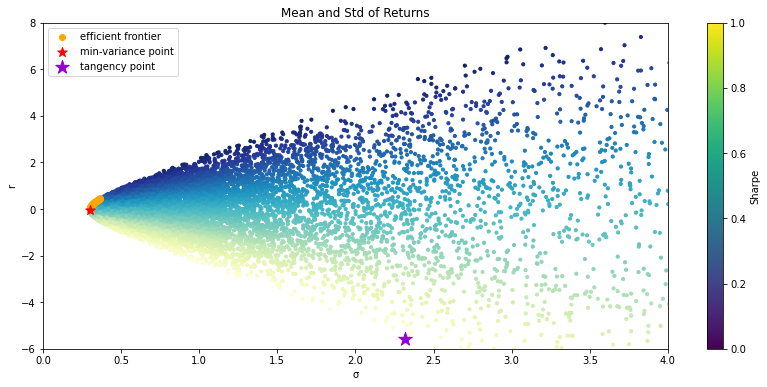

In [31]:
plt.figure(figsize=(14, 6))

# 画出可行集
plt.scatter(p_std, p_mean, c=p_sharpe, marker='o', cmap='YlGnBu', s=10)

# 标记有效前沿
plt.scatter(std_list, r_mean_list, marker='o', color='orange', label='efficient frontier')

# 标记最小方差组合
plt.scatter(least_std, least_mean, c='r', marker='*', s=100, label='min-variance point')

# 标记切点组合
plt.scatter(tan_std, tan_mean, c='darkviolet', marker='*', s=200, label='tangency point')

#plt.xlim([0.275, 0.5])
#plt.ylim([-0.8, 1])
plt.xlim([0, 4])
plt.ylim([-6, 8])
plt.xlabel('σ')
plt.ylabel('r')
plt.colorbar(label='Sharpe')
plt.legend()
plt.title('Mean and Std of Returns')
plt.show()

## 计算并绘制有效前沿

In [22]:
def eff_frontier_MM2(rp, rF=tan_mean, sigF=tan_std):
    sig = sigF * (rp - rf) / (rF - rf)
    return sig


r_list2 = np.linspace(r_min+0.5, r_min+7, 50)
std_list2 = []
for rd in r_list2:
    std = eff_frontier_MM2(rd)
    std_list2.append(std)

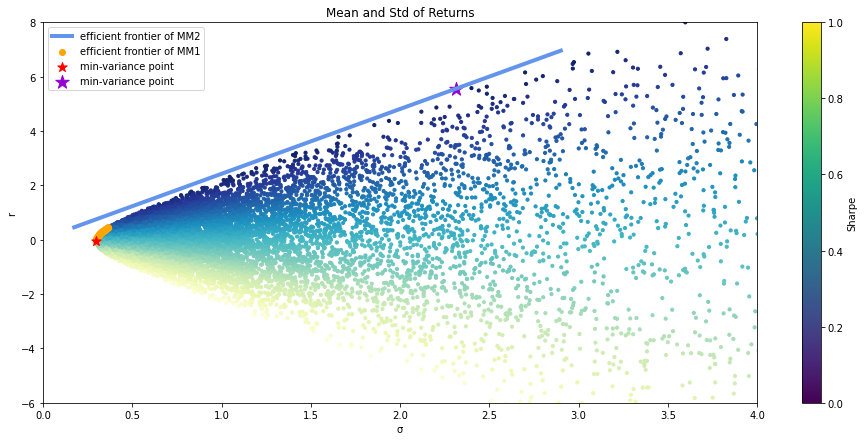

In [23]:
plt.figure(figsize=(16, 7))

# 画出可行集
plt.scatter(p_std, p_mean, c=p_sharpe, marker='o', cmap='YlGnBu', s=10)

# 标记有效前沿
plt.scatter(std_list, r_mean_list, marker='o', color='orange', label='efficient frontier of MM1')

# 标记最小方差组合
plt.scatter(least_std, least_mean, c='r', marker='*', s=100, label='min-variance point') 

# 标记切点组合
plt.scatter(tan_std, tan_mean, c='darkviolet', marker='*', s=200, label='min-variance point')

# 画出MM2的有效前沿
plt.plot(std_list2, r_list2, color='cornflowerblue', linewidth=4,
         label='efficient frontier of MM2')

plt.xlim([0, 4])
plt.ylim([-6, 8])
plt.xlabel('σ')
plt.ylabel('r')
plt.colorbar(label='Sharpe')
plt.legend()
plt.title('Mean and Std of Returns')
plt.show()